In [37]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load Data
Update_data = pd.read_excel('Update_data.xlsx')

In [3]:
Update_data.interpolate(method='linear',inplace=True)

In [6]:
#Set index 
#Update_data.set_index("Datetime")
Update_data = Update_data.set_index('Date')

In [7]:
#3. Change to DateTime 
#Update_data.index
#pd.to_datetime(Update_data.index)
Update_data.index = pd.to_datetime(Update_data.index)

In [8]:
#5. Train / Test Split 
Update_data.index < '2023-09-12 01:00:00'
Update_data.loc[Update_data.index < '2023-09-12 01:00:00' ]

train = Update_data.loc[Update_data.index < '2023-09-12 01:00:00']
test = Update_data.loc[Update_data.index >= '2023-09-12 01:00:00']

In [12]:
def create_time_feature(Update_data):
    Update_data['dayofmonth'] = Update_data.index.day
    Update_data['dayofweek'] = Update_data.index.dayofweek
    Update_data['quarter'] = Update_data.index.quarter
    Update_data['month'] = Update_data.index.month
    Update_data['year'] = Update_data.index.year
    Update_data['dayofyear'] = Update_data.index.dayofyear
   
    return Update_data

In [13]:
Update_data = create_time_feature(Update_data)

In [14]:
train = create_time_feature(train)
test = create_time_feature(test)

C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_3244\924310462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Update_data['dayofmonth'] = Update_data.index.day
C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_3244\924310462.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Update_data['dayofweek'] = Update_data.index.dayofweek
C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_3244\924310462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [15]:
train.head()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),pressure_msl (hPa),surface_pressure (hPa),...,direct_normal_irradiance (W/m²),terrestrial_radiation (W/m²),FLT GEM Debiet influent oneven kant,FLT GEM Turb influent oneven,dayofmonth,dayofweek,quarter,month,year,dayofyear
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 15:00:00,4.0,78,0.5,0.5,0.0,0.0,0.0,0.0,1002.5,1001.9,...,258.0,301.6,3483.320557,0.430411,31,3,4,12,2020,366
2020-12-31 16:00:00,3.4,85,1.0,0.6,0.0,0.0,0.0,0.0,1003.1,1002.5,...,192.7,183.6,3496.040518,0.522836,31,3,4,12,2020,366
2020-12-31 17:00:00,1.5,94,0.6,-1.6,0.0,0.0,0.0,0.0,1003.6,1003.0,...,39.9,46.2,3062.499873,0.512069,31,3,4,12,2020,366
2020-12-31 18:00:00,0.8,95,0.1,-2.3,0.0,0.0,0.0,0.0,1003.8,1003.2,...,0.0,0.0,1853.906166,0.450545,31,3,4,12,2020,366
2020-12-31 19:00:00,-0.1,97,-0.5,-3.5,0.0,0.0,0.0,0.0,1004.1,1003.5,...,0.0,0.0,2485.336366,0.405494,31,3,4,12,2020,366


In [17]:
X_train = train.drop('FLT GEM Turb influent oneven', axis =1)
y_train = train['FLT GEM Turb influent oneven']

X_test = test.drop('FLT GEM Turb influent oneven', axis =1)
y_test = test['FLT GEM Turb influent oneven']

In [24]:
#11. Fit through Model 
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)#Every 100th tree 
#Model is built 

[0]	validation_0-rmse:2.55755	validation_1-rmse:2.45454
[100]	validation_0-rmse:1.36589	validation_1-rmse:1.24398


C:\Users\Yin Jianing\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [05:06:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[152]	validation_0-rmse:1.15149	validation_1-rmse:1.33793


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

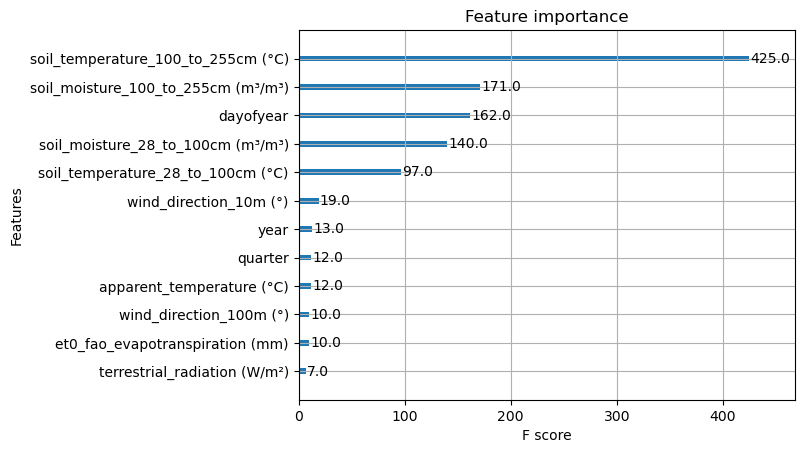

In [25]:
xgb.plot_importance(reg)

C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_3244\1399001819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


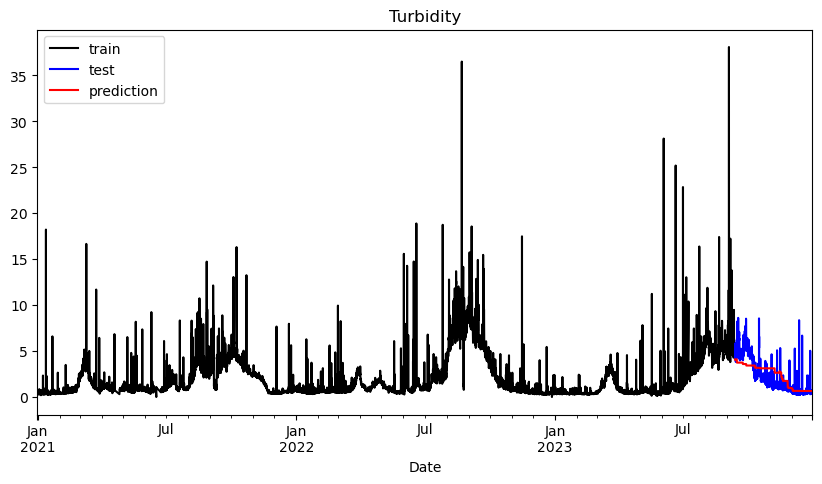

In [31]:
# Predicting / Forecasting on Test
#reg.predict(X_test)
test['prediction'] = reg.predict(X_test)

train['FLT GEM Turb influent oneven'].plot(style='k', figsize=(10,5), label = 'train')
test['FLT GEM Turb influent oneven'].plot(style='b', figsize=(10,5), label = 'test')
test['prediction'].plot(style='r', figsize=(10,5), label = 'prediction')
plt.title('Turbidity')
plt.legend()

In [38]:
# Root MSE 
print('RMSE: ', round(mean_squared_error(y_true=test['FLT GEM Turb influent oneven'],y_pred=test['prediction']),3))
print('MAE: ', round(mean_absolute_error(y_true=test['FLT GEM Turb influent oneven'],y_pred=test['prediction']),3))
print('MAPE: ', round(mean_absolute_percentage_error(y_true=test['FLT GEM Turb influent oneven'],y_pred=test['prediction']),3))

RMSE:  1.543
MAE:  0.964
MAPE:  0.646
